## 1. Download dei dati ##

In [2]:
# Download dataset
#!wget https://www.zemris.fer.hr/projects/LicensePlates/english/baza_slika.zip
# Unzip file zip
#!unzip -o -j baza_slika.zip "*.jpg" -d dataset

## 2. Preparazione dei dati ##

In [12]:
# Divisione dataset 
import os

import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io

from PIL import Image

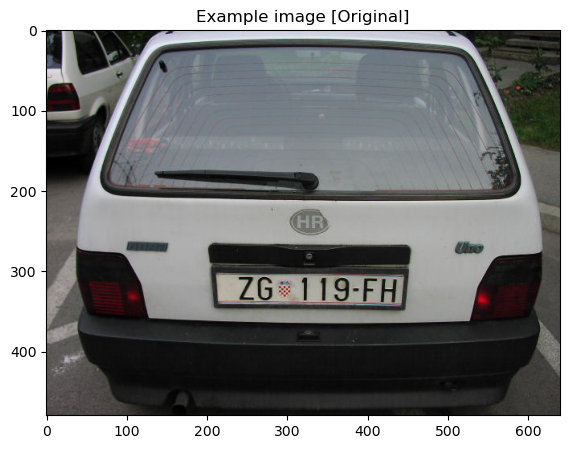

In [14]:
# Percorso alla cartella che contiene le immagini
datasetPath = "dataset"

# Lista per salvare le immagini caricate
imgList = []

# Scorrimento di tutti i file nella cartella
for fileName in os.listdir(datasetPath):
    if fileName.lower().endswith(".jpg"):
        filePath = os.path.join(datasetPath, fileName)
        img = Image.open(filePath)
        imgList.append(img)

# Mostriamo un'immagine
index = np.random.randint(0,len(imgList))
plt.figure(figsize=(15,5))
plt.imshow(imgList[index])
plt.title('Example image [Original]')
plt.show()

In [13]:
# Importiamo le librerie per il training
import torch
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
# Divisione dell'intero dataset in training set, validation set e test set (Circa 80%, 10% e 10%)
trainSet, valSet, testSet = random_split(imgList, [0.8, 0.1, 0.1])

# Creazione dei DataLoader per i set
batchSize = 60
numWorkers = 4

trainDataload = DataLoader(trainSet, batch_size=batchSize, shuffle=True, num_workers=numWorkers)
valDataload = DataLoader(valSet, batch_size=batchSize, num_workers=numWorkers)
testDataload = DataLoader(testSet, batch_size=batchSize, num_workers=numWorkers)

print("Effettuata suddivisione:")
print(f"- Training-set: {len(trainSet)} campioni.")
print(f"- Validation-set: {len(valSet)} campioni.")
print(f"- Test-set: {len(testSet)} campioni.")

Effettuata suddivisione:
- Training-set: 403 campioni.
- Validation-set: 50 campioni.
- Test-set: 50 campioni.


In [18]:
from skimage.transform import rescale, resize
from skimage.util import view_as_windows

In [ ]:

def extract_patches(img: np.ndarray, patch_size: tuple = (96, 96), stride: int = 24) -> np.ndarray:
    """
    Estrae blocchi sovrapposti da un'immagine usando finestra scorrevole.

    Args:
        img (np.ndarray): immagine di input in formato H x W x C.
        patch_size (tuple): dimensione dei blocchi (altezza, larghezza).
        stride (int): passo di estrazione in pixel.

    Returns:
        np.ndarray: array di blocchi con shape (n_h, n_w, patch_h, patch_w, C).
    """
    # Aggiungiamo dimensione canale nel passo per view_as_windows
    step = (stride, stride, img.shape[2])
    window_shape = (patch_size[0], patch_size[1], img.shape[2])
    # view_as_windows restituisce shape (n_h, n_w, 1, patch_h, patch_w, C)
    windows = view_as_windows(img, window_shape, step)
    # Rimuoviamo la dimensione singola
    patches = windows.squeeze(2)
    patches = rescale(patches,2,order=2)
    return patches

def downscale_via_average(img: str,
                           patch_size: tuple = (96, 96),
                           stride: int = 24) -> Image.Image:
    """
    Effettua il downscale di un'immagine calcolando la media di blocchi sovrapposti.

    Args:
        img_path (str): percorso dell'immagine.
        patch_size (tuple): dimensione dei blocchi.
        stride (int): passo di estrazione.

    Returns:
        PIL.Image.Image: immagine downscalata.
    """
    # Carica e converte in array
    arr = np.array(img)

    # Estrai patch
    patches = extract_patches(arr, patch_size, stride)
    n_h, n_w, _, _, c = patches.shape

    # Inizializza immagine di output
    down_h = n_h
    down_w = n_w
    downscaled = np.zeros((down_h, down_w, c), dtype=np.uint8)

    # Per ogni patch, calcola la media per canale
    for i in range(n_h):
        for j in range(n_w):
            patch = patches[i, j]
            mean_color = patch.mean(axis=(0, 1))
            downscaled[i, j] = mean_color.astype(np.uint8)

                # Converte in immagine PIL
    return Image.fromarray(downscaled)


imgLow = downscale_via_average(imgList[0])

plt.figure()
plt.imshow(imgList[0])
plt.title('Example image [Highres]')
plt.show()
plt.figure()
plt.imshow(imgLow)
plt.title('Example image [Lowres]')
plt.show()

In [ ]:
# Prova Davide 21/5/25

import numpy as np
from skimage.util import view_as_windows
from skimage.transform import resize, rescale
from skimage import img_as_float
import matplotlib.pyplot as plt
from PIL import Image

def extract_patches(img: np.ndarray, patch_size: tuple = (96, 96), stride: int = 24) -> np.ndarray:
    """
    Estrae patch sovrapposti da un'immagine RGB con finestra scorrevole.

    Returns:
        np.ndarray: array di shape (num_patches, patch_h, patch_w, C)
    """
    step = (stride, stride, 1)
    window_shape = (patch_size[0], patch_size[1], img.shape[2])
    windows = view_as_windows(img, window_shape, step)  # shape: (n_h, n_w, 1, h, w, c)
    patches = windows.squeeze(2)  # shape: (n_h, n_w, h, w, c)
    n_h, n_w, h, w, c = patches.shape
    patches = patches.reshape(-1, h, w, c)  # shape: (n_patches, 96, 96, 3)
    return patches

def degrade_patches(patches: np.ndarray, scale: int = 2) -> np.ndarray:
    """
    Degrada ogni patch riducendolo e poi interpolandolo di nuovo alla dimensione originale.

    Args:
        patches (np.ndarray): array di patch HR di shape (N, H, W, C)
        scale (int): fattore di riduzione.

    Returns:
        np.ndarray: patch degradati/interpolati di shape (N, H, W, C)
    """
    degraded = []
    for patch in patches:
        h, w, c = patch.shape
        # Downscale
        small = rescale(patch, 1/scale, order=1, channel_axis=-1)
        # Upscale back
        upsampled = rescale(small, scale, order=1, channel_axis=-1)
        degraded.append(upsampled)
    return np.stack(degraded, axis=0)

def prepare_input_target_from_image(img: np.ndarray, patch_size=(96, 96), stride=24, scale=2):
    """
    Genera input e target per l'addestramento da un'immagine RGB.

    Returns:
        input_patches: patch interpolati (low-res → high-res)
        residual_patches: patch HR - patch interpolati
    """
    img = img_as_float(img)  # normalizza in [0, 1]
    patches_hr = extract_patches(img, patch_size, stride)  # HR patches
    patches_interp = degrade_patches(patches_hr, scale)    # interpolated
    residuals = patches_hr - patches_interp                # residui
    return patches_interp.astype(np.float32), residuals.astype(np.float32)


def reconstruct_from_patches(patches, image_shape, patch_size=(96, 96), stride=24):
    """
    Ricostruisce l'immagine originale combinando i patch sovrapposti.

    Args:
        patches (np.ndarray): array di shape (N, patch_h, patch_w, C)
        image_shape (tuple): shape originale dell'immagine (H, W, C)
        patch_size (tuple): dimensione dei blocchi (altezza, larghezza)
        stride (int): passo tra i blocchi

    Returns:
        np.ndarray: immagine ricostruita
    """
    h, w, c = image_shape
    ph, pw = patch_size

    reconstructed = np.zeros((h, w, c), dtype=np.float32)
    weight = np.zeros((h, w, c), dtype=np.float32)

    idx = 0
    for i in range(0, h - ph + 1, stride):
        for j in range(0, w - pw + 1, stride):
            reconstructed[i:i+ph, j:j+pw] += patches[idx]
            weight[i:i+ph, j:j+pw] += 1
            idx += 1

    # Evitiamo divisione per zero
    weight[weight == 0] = 1
    return (reconstructed / weight).clip(0, 1)


    

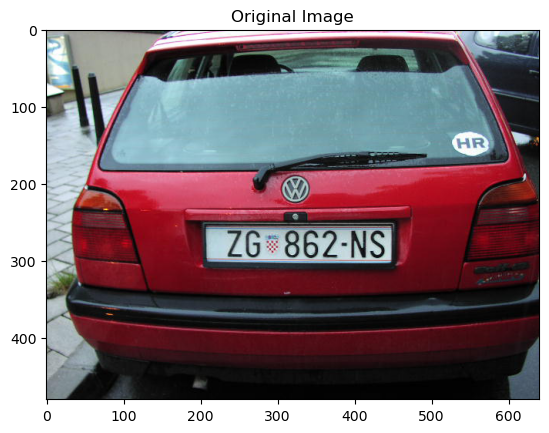

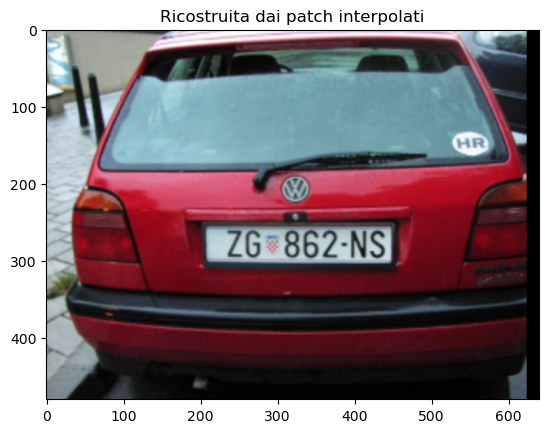

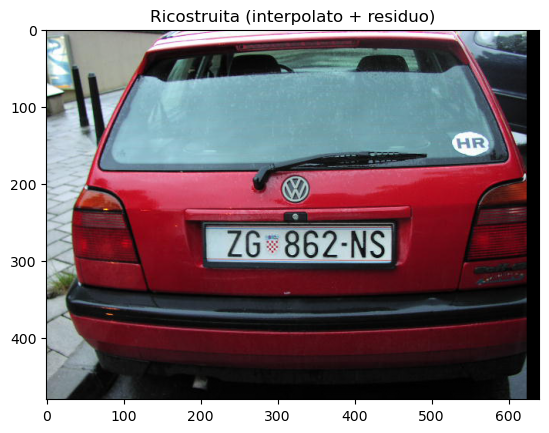

In [42]:
from PIL import Image
import numpy as np
from numpy import random


# Se hai una lista di immagini PIL
index = random.randint(0,200)
# Estrai patch da un'immagine
img_np = np.array(imgList[index])
x_patches, y_residuals = prepare_input_target_from_image(img_np)

# Ricostruisci immagine dai patch interpolati (low-res + upsampled)
reconstructed_interp = reconstruct_from_patches(x_patches, img_np.shape)

# Ricostruisci immagine HR = interpolata + residuo
reconstructed_hr = reconstruct_from_patches(x_patches + y_residuals, img_np.shape)

# Visualizza
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img_np)
plt.title("Original Image")

plt.figure()
plt.imshow(reconstructed_interp)
plt.title("Ricostruita dai patch interpolati")

plt.figure()
plt.imshow(reconstructed_hr)
plt.title("Ricostruita (interpolato + residuo)")
plt.show()

